# <font color="Yellow">*Code by: Shayan Rokhva | contant me via shayanrokhva1999@gmail.com*


## <font color="orange">*Instruction*

##### <font color="Pink">**Dataset: Food 11 - Type: Image-based Classification - Method: CNN - Model: MobileNetV2 - Why this model: Low Computational Cost and Time While Maintaining Excellent Performance at the same time - Applying: Transfer Learning (full fine tune) + Fully Equipped Optimizer (SGD + LR + Momentum + L2 Regularizer + Neterov) + Dynamic LR which reduces over epochs (Learning rate scheduler) + Charts & Confusion matrix + Discussion**


## <font color="orange">*Mouting google drive & checking for hardware accelerator*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!nvidia-smi

Fri May 24 07:34:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color="orange">*Importing & Installing libraries and metrics*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import os
import glob
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from   torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torchvision.datasets as datasets

!pip install tqdm
from tqdm import tqdm

from PIL  import Image

!pip install torchmetrics
from torchmetrics import Accuracy, F1Score, Precision, Recall       # Accuracy, Precision, Recall, F1score    # All may not be required


# NOTE => Some may not be needed at all. Nonethless, this provides a general code.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## <font color="orange">*Data Loading*

#### <font color="yellow">*Transfering files from google drive to google colab virtual machine (indeed vital for speedy code)*

In [ ]:
!cp -r /content/gdrive/MyDrive/training /content/
!cp -r /content/gdrive/MyDrive/validation /content/
!cp -r /content/gdrive/MyDrive/evaluation /content/

In [ ]:
training_folder    =  "/content/training"
validation_folder  =  "/content/validation"
evaluation_folder  =  "/content/evaluation"

## <font color="orange">*Defining the image size (Striking a balance between speed and metrics satisfaction)*


#### <font color="yellow">*Image size plays a pivotal role in both speed and accuracy of your findings*

In [ ]:
image_size = 256  # The image is going to be: (image_size)*(image_size)   => can be modified as required

# NB:
# Recommended image sizes to test => 32, 64, 128, 256
# According to the literature 128, 224, and 256 are widely in use and highly recommended for a typical GPU.

## <font color="orange">*Data Transformation & Augmentation*


In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]      # for Normalization (Zero-Centering) - MEAN and STD are used from ImageNet

# Normalization (Zero-Centering) using the MEAN and STD of ImageNet (application of transfer learning).
# According to the literature, when applying transfer learning, it is a good idea (good enough) to use MEAN and STD from Imagenet dataset.
# While the MEAN and STD for this dataset can be slightly different, it has been proved that the proposed method will work perfectly.

In [ ]:
# NB
# ==============================================================================================================================================
# ==============================================================================================================================================
# It is crucial to highlight the importance of  normalization process for training, validation, and evaluation all (next line)=>
# In a general application (no transfer learning), the MEAN and STD must be extracted only and only form the training set and applied to all
# but now =>
# Since we are using transfer learning and weights and bias come from Imagenet dataset, we can easily use the weights and bias from Imagenet.
# The real MEAN and STD of this dataset can be slightly different. Nonethless, it is found that utilizing these wrights also work perfectly.
# ==============================================================================================================================================
# ==============================================================================================================================================

In [ ]:
# This is the data augmentation part. One can modify to satisy their specific needs and requirements.
# ============================================================================================================

# main_transfrom
main_transform = T.Compose([
                            T.Resize((image_size , image_size)),    # Resizing
                            T.ToTensor(),                           # PIL to Tensor
                            T.Normalize(mean, std)                  # Normalization / Zero-centering
                           ])



# augment_transfrom
augment_transform = T.Compose([
                              T.Resize((image_size , image_size)),  # Resizing
                              T.RandomRotation(degrees = 30),       # Random Rotation with some degrees (up to 30 degree)
                              T.RandomHorizontalFlip(p = 0.5),      # 50% of training smaple will have Random Horizontal Flip
                              T.ColorJitter(0.1 , 0.1 , 0.1),       # Transform image color with random changes (slightly)
                              T.ToTensor(),                         # PIL to Tensor
                              T.Normalize(mean, std),               # Normalization / Zero-centering
                              T.RandomErasing(p = 0.5)              # Randomly Erase parts for Augmentation for 50% of training samples
                              ])


# ============================================================================================================
# The augment_transfrom will only be used for "training" data, helping the model learn more varied data samples.
# We do not augment the validation and evaluation data in here.
# This part can be modified to satisfy different undertaken tasks.

## <font color="orange">*Creating TensorDatasets*

In [ ]:
train_set =  datasets.ImageFolder(training_folder   , transform = augment_transform)    # Augmentation only for Training
valid_set =  datasets.ImageFolder(validation_folder , transform = main_transform)       # No Augmentation
eval_set  =  datasets.ImageFolder(evaluation_folder , transform = main_transform)       # No Augmentation

In [ ]:
len(train_set)         # must be 9866

9866

In [ ]:
len(valid_set)         # must be 3439

3439

In [ ]:
len(eval_set)          # must be 3347

3347

## <font color="orange">*Data distribution and compehension (for each subset)*


#### <font color="yellow">*How many data points are avaliable in each subset? How many data points are assigned to each class in each subset? The answers reflect the distribution of data in each subset. Whether or not we have balaenced data?*

In [ ]:
from collections import Counter

# Assuming 'train_set.targets' contains the class labels for each sample
class_counts = Counter(train_set.targets)

# Now 'class_counts' is a dictionary where the keys are the class labels and the values are the counts

# You can print the class names, indices, and counts like this:
for class_name, class_idx in train_set.class_to_idx.items():
    print(f'For Training =>     Class: {class_name:<20} Index: {class_idx:<10} Count: {class_counts[class_idx]}')

print("")
print(f"NOTE: The total number of data in Training set is:  {len(train_set)}")       # must be 9866

For Training =>     Class: Bread                Index: 0          Count: 994
For Training =>     Class: Dairy product        Index: 1          Count: 429
For Training =>     Class: Dessert              Index: 2          Count: 1500
For Training =>     Class: Egg                  Index: 3          Count: 986
For Training =>     Class: Fried food           Index: 4          Count: 848
For Training =>     Class: Meat                 Index: 5          Count: 1325
For Training =>     Class: Noodles-Pasta        Index: 6          Count: 440
For Training =>     Class: Rice                 Index: 7          Count: 280
For Training =>     Class: Seafood              Index: 8          Count: 855
For Training =>     Class: Soup                 Index: 9          Count: 1500
For Training =>     Class: Vegetable-Fruit      Index: 10         Count: 709

NOTE: The total number of data in Training set is:  9866


In [ ]:
from collections import Counter

# Assuming 'valid_set.targets' contains the class labels for each sample
class_counts = Counter(valid_set.targets)

# Now 'class_counts' is a dictionary where the keys are the class labels and the values are the counts

# You can print the class names, indices, and counts like this:
for class_name, class_idx in valid_set.class_to_idx.items():
    print(f'For Validation =>     Class: {class_name:<20} Index: {class_idx:<10} Count: {class_counts[class_idx]}')

print("")
print(f"NOTE: The total number of data in Validation set is:  {len(valid_set)}")     # must be 3430

For Validation =>     Class: Bread                Index: 0          Count: 362
For Validation =>     Class: Dairy product        Index: 1          Count: 144
For Validation =>     Class: Dessert              Index: 2          Count: 500
For Validation =>     Class: Egg                  Index: 3          Count: 327
For Validation =>     Class: Fried food           Index: 4          Count: 326
For Validation =>     Class: Meat                 Index: 5          Count: 449
For Validation =>     Class: Noodles-Pasta        Index: 6          Count: 147
For Validation =>     Class: Rice                 Index: 7          Count: 96
For Validation =>     Class: Seafood              Index: 8          Count: 347
For Validation =>     Class: Soup                 Index: 9          Count: 509
For Validation =>     Class: Vegetable-Fruit      Index: 10         Count: 232

NOTE: The total number of data in Validation set is:  3439


In [ ]:
from collections import Counter

# Assuming 'eval_set.targets' contains the class labels for each sample
class_counts = Counter(eval_set.targets)

# Now 'class_counts' is a dictionary where the keys are the class labels and the values are the counts

# You can print the class names, indices, and counts like this:
for class_name, class_idx in eval_set.class_to_idx.items():
    print(f'For Evaluation =>     Class: {class_name:<20} Index: {class_idx:<10} Count: {class_counts[class_idx]}')

print("")
print(f"NOTE: The total number of data in Evaluation set is:  {len(eval_set)}")    # must be 3347

For Evaluation =>     Class: Bread                Index: 0          Count: 368
For Evaluation =>     Class: Dairy product        Index: 1          Count: 148
For Evaluation =>     Class: Dessert              Index: 2          Count: 500
For Evaluation =>     Class: Egg                  Index: 3          Count: 335
For Evaluation =>     Class: Fried food           Index: 4          Count: 287
For Evaluation =>     Class: Meat                 Index: 5          Count: 432
For Evaluation =>     Class: Noodles-Pasta        Index: 6          Count: 147
For Evaluation =>     Class: Rice                 Index: 7          Count: 96
For Evaluation =>     Class: Seafood              Index: 8          Count: 303
For Evaluation =>     Class: Soup                 Index: 9          Count: 500
For Evaluation =>     Class: Vegetable-Fruit      Index: 10         Count: 231

NOTE: The total number of data in Evaluation set is:  3347


## <font color="orange">*DataLoaders, their checks and comprehension*



#### <font color="yellow">*Creating train, valid, and eval loader + ensuring randomness*


In [ ]:
train_loader = DataLoader(train_set , batch_size=64  , shuffle=True)     # Shuffle must be True => Ensuring a complete randomness in training
valid_loader = DataLoader(valid_set , batch_size=128 , shuffle=True)
eval_loader  = DataLoader(eval_set  , batch_size=128 , shuffle=True)

# batch_size for validation and evaluation can be higher as there will be no gradients and backpropagation.

#### <font color="yellow">*Comprehension & checking dimenions, sizes and randomness in loaders. Train loader as an example.*


In [ ]:
# This is a test => to see whether or not this works OK.

# one batch / next batch
x , y = next(iter(train_loader))     # just one single batch from train_loader

# some info
print(f"Imgae size is {image_size}*{image_size}")
print("")

print("For Train_loader:")
print(f"x.shape is: {x.shape}")      # must be: [BS*3*image_size*image_size]
print(f"y.shape is: {y.shape}")      # must be: [BS]
print("")
# NB:
# Assuming that batch size and image size are 64 and 256, you must be given [64,3,256,256] for a typical RGB image for X and [64] for y.


# A good batch size (BS) must represent almost all the classes (must be representative)
print("All the classes (class indices) available in this batch:")
print(y)

Imgae size is 256*256

For Train_loader:
x.shape is: torch.Size([64, 3, 256, 256])
y.shape is: torch.Size([64])

All the classes (class indices) available in this batch:
tensor([ 6,  2,  3,  3,  9,  2,  4,  3, 10,  1, 10,  8,  5,  2,  2,  8,  9, 10,
         5,  0,  2,  0,  9,  9,  5,  2,  3,  3,  0,  8,  9,  5, 10,  0, 10, 10,
         2, 10,  8, 10, 10,  8,  5,  5,  0,  2,  1,  6,  8, 10,  3,  0,  5,  3,
         9,  5,  9,  1,  5,  1,  1,  9,  5,  3])


## <font color="orange">*Some Visualization*

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]] , fontsize=12)
    ax.axis('off')

  # Save the figure with the name 'Figure 2' and with exactly 600 DPI
  fig.savefig('Data augmentation figure.jpeg', dpi=600)

#### <font color="yellow">*Data visualization you'll see belongs to some random training samples after applying data transformation and augmentaion*



NOTE 1: Image size is: 256*256 
NOTE 2: The data you'll see belongs to some random training samples after applying data transformation and augmentation



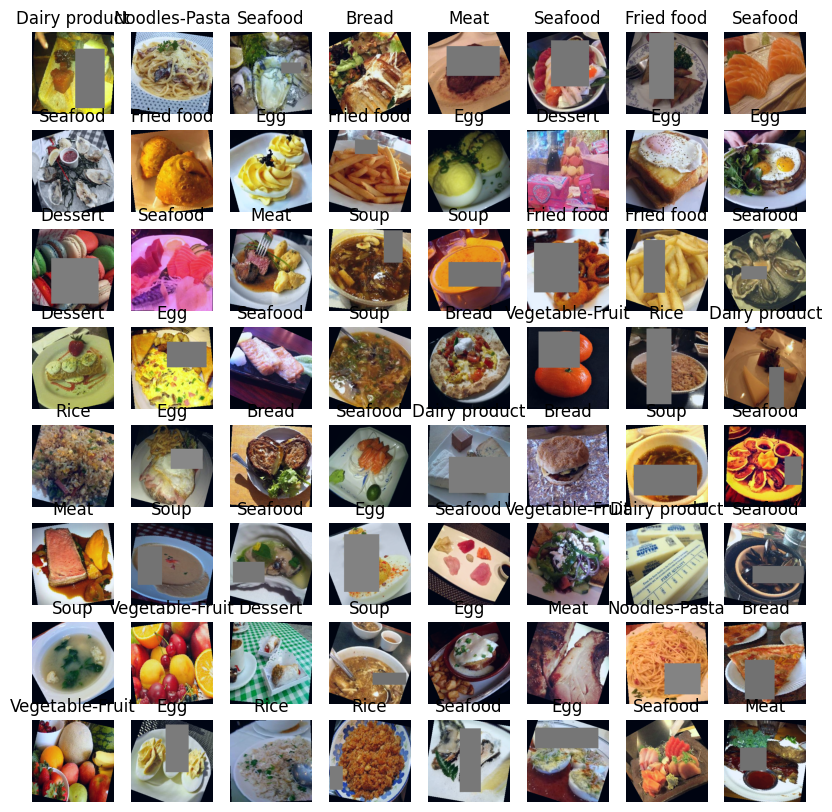

In [ ]:
print(f"NOTE 1: Image size is: {image_size}*{image_size} ")
print(f"NOTE 2: The data you'll see belongs to some random training samples after applying data transformation and augmentation")
print("")

batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# Figure below provides a visual representation of some randomly selected training samples -
# along with their corresponding classes on top of them, after the application of data augmentation.

#### <font color="yellow"> Tip and Tricks => 1) We recommend that you change the image size and see its impacts on the visualization. The image sizes which are below 128*128 (or something like that) are not very clear. 2) Consequently, we suggest that if you have a GPU accelerator and if you want to see and evaluate your model performance, image sizes which are below 128 should be avioded. 3) Nonethless, chaning image size to low numbers like 32 (CIFAR10 image size) in order to check whether you code works OK or not is indeed a good and highly recommended idea.


## <font color="orange">*Comparing some computer vision models in terms of parameters on ImageNet (1000 classes)*

In [ ]:
# import torch
# from torchvision import models

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# List of models to be imported
model_names = ['vgg16', 'vgg19', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
               'googlenet', 'mobilenet_v1', 'mobilenet_v2', 'shufflenet_v2_x1_0']

# Dictionary to store the models and their parameters
models_dict = {}

# Import the models and count their parameters
for model_name in model_names:
    try:
        # Import the model
        model = getattr(models, model_name)(pretrained=False)      # No difference between True and False in here

        # Count the parameters
        num_params = count_parameters(model)

        # Store the model and its parameters in the dictionary
        models_dict[model_name] = num_params

        # Print the model name and its parameters
        print(f"{model_name} has {num_params / 1e6} million parameters")

    except Exception as e:
        print(f"==================>    Could not import {model_name}. Error: {e}")

# Print the total parameters for all models
print(f"\nTotal parameters for all models: {sum(models_dict.values()) / 1e6} million")


# ======================================================================================================================
# ======================================================================================================================
# NB
# There is NO difference between True/Flase in here for pretrained.
# My main focus is that it must be ImageNet with 1000 classes at classifier.
# Even the number of data in different version of ImageNet is not important for me, 1000 classes are important.
# And since we have not freezed any trainable paramter, the number of all and trainable parametrs will be the same.
# ======================================================================================================================
# ======================================================================================================================


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


vgg16 has 138.357544 million parameters
vgg19 has 143.66724 million parameters
resnet18 has 11.689512 million parameters
resnet34 has 21.797672 million parameters
resnet50 has 25.557032 million parameters
resnet101 has 44.54916 million parameters
resnet152 has 60.192808 million parameters


/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


googlenet has 13.004888 million parameters
==================>    Could not import mobilenet_v1. Error: module 'torchvision.models' has no attribute 'mobilenet_v1'
mobilenet_v2 has 3.504872 million parameters
shufflenet_v2_x1_0 has 2.278604 million parameters

Total parameters for all models: 464.599332 million


In [ ]:
# Install the EfficientNet-PyTorch library
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=a20ca3ba8dd2517761531d837b6a61ebb007a75647043613087c3a5cd6890631
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# # Install the EfficientNet-PyTorch library
# !pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet

# List of EfficientNet models to be imported
model_names = ['efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3',
               'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7']

# Dictionary to store the models and their parameters
models_dict = {}

# Import the models and count their parameters
for model_name in model_names:
    try:
        # Import the model
        model = EfficientNet.from_name(model_name)

        # Count the parameters
        num_params = count_parameters(model)

        # Store the model and its parameters in the dictionary
        models_dict[model_name] = num_params

        # Print the model name and its parameters
        print(f"{model_name} has {num_params / 1e6} million parameters")

    except Exception as e:
        print(f"Could not import {model_name}. Error: {e}")

# Print the total parameters for all models
print(f"\nTotal parameters for all models: {sum(models_dict.values()) / 1e6} million")

efficientnet-b0 has 5.288548 million parameters
efficientnet-b1 has 7.794184 million parameters
efficientnet-b2 has 9.109994 million parameters
efficientnet-b3 has 12.233232 million parameters
efficientnet-b4 has 19.341616 million parameters
efficientnet-b5 has 30.389784 million parameters
efficientnet-b6 has 43.040704 million parameters
efficientnet-b7 has 66.34796 million parameters

Total parameters for all models: 193.546022 million


In [ ]:
# Given dictionary of model names and their corresponding parameter counts
parameter_counts = {
    "VGG16": 138.4,
    "VGG19": 143.7,
    "ResNet18": 11.7,
    "ResNet34": 21.8,
    "ResNet50": 25.6,
    "ResNet101": 44.5,
    "ResNet152": 60.2,
    "GoogleNet": 13.0,
    "MobileNetV2": 3.5,
    "EfficientNetB0": 5.3,
    "EfficientNetB1": 7.8,
    "EfficientNetB2": 9.1,
    "EfficientNetB3": 12.2,
    "EfficientNetB4": 19.3,
    "EfficientNetB5": 30.4,
    "EfficientNetB6": 43.0,
    "EfficientNetB7": 66.3
}

# Create a new dictionary sorted by parameter counts (ascending order)
sorted_parameters = dict(sorted(parameter_counts.items(), key=lambda item: item[1]))

# Print the sorted dictionary
print(sorted_parameters)

{'MobileNetV2': 3.5, 'EfficientNetB0': 5.3, 'EfficientNetB1': 7.8, 'EfficientNetB2': 9.1, 'ResNet18': 11.7, 'EfficientNetB3': 12.2, 'GoogleNet': 13.0, 'EfficientNetB4': 19.3, 'ResNet34': 21.8, 'ResNet50': 25.6, 'EfficientNetB5': 30.4, 'EfficientNetB6': 43.0, 'ResNet101': 44.5, 'ResNet152': 60.2, 'EfficientNetB7': 66.3, 'VGG16': 138.4, 'VGG19': 143.7}


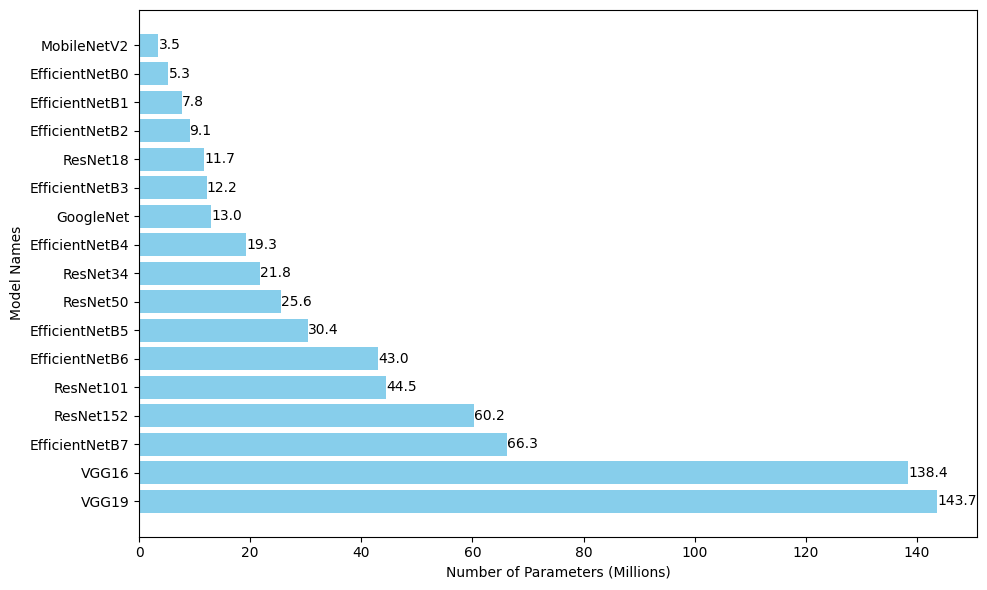

In [ ]:
import matplotlib.pyplot as plt

# Extract model names and parameter counts from the sorted_parameters dictionary
model_names = list(sorted_parameters.keys())
parameter_counts_millions = list(sorted_parameters.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, parameter_counts_millions, color='skyblue')
plt.xlabel('Number of Parameters (Millions)')
plt.ylabel('Model Names')
# plt.title('Number of Parameters in Different Well-Known Models')
plt.gca().invert_yaxis()  # Invert Y-axis to show models from low to high

# Add labels for parameter counts on top of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.1f}",
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()

# Save the modified figure as "figure3.jpeg" with DPI=600
plt.savefig("Models' parameter counts figure.jpeg", dpi=600)

# Show the plot
plt.show()


In [ ]:
import torch
from torchvision import models           # GoogleNet

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
# Load GoogLeNet (Inception v1) from torchvision
googlenet = models.googlenet()

# Count the parameters
num_params = count_parameters(googlenet)

# Print the number of parameters
print(f"GoogLeNet (Inception v1) has {num_params / 1e6} million parameters")


GoogLeNet (Inception v1) has 13.004888 million parameters


## <font color="orange">*Model 🧠 + Transfer Learning*



#### <font color="yellow">*We usually import models and customize them. There is no point strating form scrach. We usually leverage transfer learning. Whatever we use can be found here*


In [ ]:
# Load the pre-trained model
model = models.mobilenet_v2(weights = "MobileNet_V2_Weights.IMAGENET1K_V1")

# Modify the last layer with 11 classes  => (Imagenet has 100 classes. Thus, this must be modified)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 11)   # 11 classes

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 52.2MB/s]


In [ ]:
# # Checking the model
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## <font color="orange">*Number of parameters in the model (how light the model is?)*

In [ ]:
# Number of parameters in this CNN model
def number_of_parameters(model):
  number_of_params = sum(parameter.numel() for parameter in model.parameters()) / 1e6
  return number_of_params

print(f"the model has   {number_of_parameters(model):.5}    million parameters to be optimized")

the model has   2.238    million parameters to be optimized


#### <font color="yellow">*It is always a good idea to compare the number of your model's parameters with the number of parameters in other world-famous models (Resnets, VGGs, Efficientnets, MobileNets). We must keep in mind that the number of trainable parameters, those which are affected by backpropagation, must be compared (in case of transfer learning). Furhtermore, since it has a direct impact on model's trainable parameters, the modification in the FC layer (when customizing the model) must also be taken into account.*

## <font color="orange">*Device ⚙️ (GPU , CPU)*

In [ ]:
# Defining the device (CPU / GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# MODEL => to device
model = model.to(device)

In [ ]:
device

'cuda'

## <font color="orange">*Loss Function & Optimizer ⚖️*

In [ ]:
# Loss Function => Multiclass Classification => Cross Entropy Loss
loss_function = nn.CrossEntropyLoss()

# Optimizer => SGD + LR + Momentum + Nesterov accelerator + WD regularization => Parameters may be changed later (will be tuned later)
optimizer = optim.SGD(model.parameters() , lr = 0.001 , momentum = 0.9 , nesterov = True , weight_decay = 1e-4)

# NB
# Cross Entropy Loss is an appropriate loss function for a multiclass classification problem.
# Hyperparameters will be tuned further. However, the initial LR has been set to be 1e-3 (smaller than 0.1 or 0.01) as we have applied transfer learning.
# 0.9 for momentum and 1e-4 for weight decay (L2 regularization) are found to be good and suitable in most applications according to the literature.
# 0.9 for momentum is widely in use. 1e-3 and 1e-4 are good options. Therefore, in here I have chosen 1e-4.

In [ ]:
# Checking loss function
loss_function

CrossEntropyLoss()

In [ ]:
# Checking optimizer
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0001
)

## <font color="orange">*Learning Rate Schedualer*

In [ ]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer , step_size=10 , gamma=0.1)   # lr_scheduler.step() => must be applied later

# This is just recommended in here.
# Its useful application will be applied after tuning the hyperparamters later, with much more caution.

## <font color="orange">*Utills 🧰 (helpful for updating LOSS)*



#### <font color="yellow">*This is a ready class for updating LOSS conveniently*



In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

    def get_avg(self):
        """Returns the current average value"""
        return self.avg

## <font color="orange">*Functions 🧮 (Training - Validation|Evaluation)*

#### <font color="yellow">*You'll see 2 functions*
#### <font color="yellow">*Function1 => training for 1 poch*
#### <font color="yellow">*Function2 => evaluation for 1 epoch*

In [ ]:
def train_one_epoch(model, loader, loss_function, optimizer, epoch=None):

  # train phase, a flag   (This is essential)
  model.train()

  # AverageMeter for LOSS train
  loss_train = AverageMeter()

  # Accuracy
  accuracy_train     =  torchmetrics.Accuracy    (task="multiclass", num_classes=11, average="macro").to(device)

  # Reset metrics at the start of each epoch (essential)
  loss_train.reset()
  accuracy_train.reset()

  # FOR loop => across different batches
  for inputs, targets in tqdm(loader, unit="batch"):   # tqdm with batches

    # both inputs and targets => to device
    inputs, targets = inputs.to(device), targets.to(device)

    # inputs => model => outputs
    outputs = model(inputs)

    # loss train => this is for each batch
    loss = loss_function(outputs, targets)

    # back propagation, updating weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # updating and saving metrics for train
    # NB => This updating process must be *inside* the for loop to represents all the batches of one epoch.
    # NB => If it was written outside of the for loop, it would represent the result for only the last batch, which is incorrect.
    loss_train.update      (  loss.item()             , inputs.size(0) )
    accuracy_train.update  (  outputs.softmax(dim=-1) , targets.int()  )


    # End of for loop here


  # Compute average metrics over all batches in this 1 epoch
  avg_loss_train       = loss_train.avg
  avg_accuracy_train   = accuracy_train.compute().item()


  # LOSS , ACC
  return avg_loss_train, avg_accuracy_train


In [ ]:
def evaluation(model, loader, loss_function):

  # evaluation phase, a flag (essential)
  model.eval()

  # AverageMeter for LOSS eval
  loss_eval = AverageMeter()

  # Accuracy
  accuracy_eval     =  torchmetrics.Accuracy    (task="multiclass", num_classes=11, average="macro").to(device)


  # Reset metrics at the start of each epoch (essential)
  loss_eval.reset()
  accuracy_eval.reset()


  # NO gradient is required for evaluation (test)
  with torch.no_grad():  # essential

    # FOR loop => across different batches
    for inputs, targets in tqdm(loader, unit="batch"):

      # both inputs and targets => to device
      inputs, targets = inputs.to(device), targets.to(device)

      # inputs => model => outputs
      outputs = model(inputs)


      # loss eval => this is for each batch
      loss = loss_function(outputs, targets)


      # NO backpropagation, NO optimizer


      # updating and saving metrics for validation/evaluation (no train process)
      # NB => This updating process must be *inside* the for loop to represents all the batches of one epoch.
      # NB => If it was written outside of the for loop, it would represent the result for only the last batch, which is incorrect.
      loss_eval.update(        loss.item()             , inputs.size(0) )
      accuracy_eval.update(    outputs.softmax(dim=-1) , targets.int()  )


      # End of for loop here



  # Compute average metrics over all batches for this 1 epoch
  avg_loss_eval       = loss_eval.avg
  avg_accuracy_eval   = accuracy_eval.compute().item()


  # LOSS , ACC
  return avg_loss_eval, avg_accuracy_eval


## <font color="orange">*Checking initial metrics for all subsets (provides a better understanding)*

#### <font color="yellow">*Checking initial metrics for all training - validation - evaluation subsets. Since this is checked now and before any kind of training, it can work as a sort of  initial metric*



In [ ]:
import torchmetrics     # we do this again

In [ ]:
# Since we want the model's performance without any train (0 epoch) we must use the "evaluation" function.

for epoch in range(1):     # range1 = 0
  # Initial metrics for training
  initial_train_loss , initial_train_accuracy  = evaluation(model, train_loader, loss_function)
  print(f" Initial Train LOSS      (no train):  {initial_train_loss:.4}"       )
  print(f" Initial Train Accuracy  (no train):  {initial_train_accuracy:.4}"   )
  print("")

for epoch in range(1):     # range1 = 0
  # Initial metrics for validation
  initial_valid_loss , initial_valid_accuracy = evaluation(model, valid_loader, loss_function)
  print(f" Initial Valid LOSS      (no train):  {initial_valid_loss:.4}"       )
  print(f" Initial Valid Accuracy  (no train):  {initial_valid_accuracy:.4}"   )
  print("")

for epoch in range(1):     # range1 = 0
  # Initial metrics for evaluation
  initial_eval_loss , initial_eval_accuracy  = evaluation(model, eval_loader, loss_function)
  print("")
  print(f" Initial Eval LOSS      (no train):   {initial_eval_loss:.4}"        )
  print(f" Initial Eval Accuracy  (no train):   {initial_eval_accuracy:.4}"    )
  print("")

print("NB: These are the initial metrics without any training process (like Epoch=0)")

100%|██████████| 155/155 [01:22<00:00,  1.87batch/s]


 Initial Train LOSS      (no train):  2.49
 Initial Train Accuracy  (no train):  0.08982



100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


 Initial Valid LOSS      (no train):  2.48
 Initial Valid Accuracy  (no train):  0.0843



100%|██████████| 27/27 [00:13<00:00,  2.06batch/s]


 Initial Eval LOSS      (no train):   2.487
 Initial Eval Accuracy  (no train):   0.08736

NB: These are the initial metrics without any training process (like Epoch=0)


#### <font color="yellow">*Assuming taht all the data come from the same distribution, they generally must have close LOSS and other metrics.*



In [ ]:
# NB
# If all the data come from the same distribution, they generally must have LOSS (or other metrics) in colse proxemity to each other.
# Checked
# Passed => all losses seem to be close
# Done

## <font color="red">*Hyper-Parameter Tunning Utilizing Validation Set (Includes warning, check that at the beginning)*



#### <font color="red">**Warning:**
#### <font color="red">*This section, which is associated with expermenets of hyperparameter tuning make take a while even with GPU. Please consider these: 1) Please do NOT use CPU at all, GPU only. 2) Assuming that you trust our findings, we recommened NOT to run the code. Since we have written the findings of our experiments, you can have a look at them. 3) Image size can be influential in the speed of the code. However, it must not be set too low as the model cannot perform well on low-quality data. We should strike a balance.*


#### <font color="yellow">*Experimnet 1 => Choosing the most appropriate inital value for learning rate (WD is 0 for now)*




In [ ]:
# num_epochs = 5        # 5 epochs will meet our requirements for hyperparameter tuning (in here)


# # for LR in [0.1 , 0.01 , 0.001 , 0.0001]  => Choosing the initial learning rate for now
# # In this stage, we intend to find the best LR to start with. It will be modified with LR scheduler later.
# # ====================================
# loss_train_01     = []
# loss_train_001    = []
# loss_train_0001   = []
# loss_train_00001  = []

# loss_valid_01     = []
# loss_valid_001    = []
# loss_valid_0001   = []
# loss_valid_00001  = []   # NB => For hyperparameter tuning, we only look at validation LOSS, not other metrics, the LOSS is good enough in here.
# # ====================================




# for LR in [0.1, 0.01, 0.001, 0.0001]:    # Just tuning the LR for now, using only 5 epochs of training and evaluation on validation

#   print(f'                      LR={LR}                      ')
#   print("====================================================")
#   print("====================================================")


#   # Initialization / Settings (for each LR from the beginning) => This step is vital
#   # ==============================================================================
#   model = models.mobilenet_v2(weights = "MobileNet_V2_Weights.IMAGENET1K_V1")
#   num_ftrs = model.classifier[1].in_features
#   model.classifier[1] = nn.Linear(num_ftrs, 11)
#   model = model.to(device)
#   # ==============================================================================
#   loss_function = nn.CrossEntropyLoss()
#   # ==============================================================================
#   optimizer = optim.SGD(model.parameters() , lr = LR , momentum = 0.9 , nesterov = True , weight_decay =0)   # WD = 0
#   # learning rate is LR and WD is 0 for now.
#   # ==============================================================================
#   # lr_scheduler = optim.lr_scheduler.StepLR(optimizer , step_size=10 , gamma=0.1)



#   # Applying each LR
#   for epoch in range(num_epochs):

#       # Training the model
#       loss_train , _ , _ , _ , _ = train_one_epoch(model, train_loader , loss_function , optimizer , epoch)

#       # Validation results
#       loss_valid , _ , _ , _ , _ = evaluation(model, valid_loader , loss_function)    # valid loader
#       # This is for validation. No oprimizer and backprop.


#       # Printing the results for Validation (for hyper-parameter tuning we only evaluate validation results)
#       print(f"Epoch: {epoch+1} / {num_epochs}")    # First epoch is Epoch1
#       print(f"Train LOSS = {loss_train:.4}")
#       print(f"Valid LOSS = {loss_valid:.4}")
#       print("=============================")

#       # Saving the validation loss => Aim to plot this later (Validation loss)
#       if LR==0.1:
#         loss_valid_01.append(loss_valid)
#       if LR==0.01:
#         loss_valid_001.append(loss_valid)
#       if LR==0.001:
#         loss_valid_0001.append(loss_valid)
#       if LR==0.0001:
#         loss_valid_00001.append(loss_valid)

#       # Saving the train loss
#       if LR==0.1:
#         loss_train_01.append(loss_train)
#       if LR==0.01:
#         loss_train_001.append(loss_train)
#       if LR==0.001:
#         loss_train_0001.append(loss_train)
#       if LR==0.0001:
#         loss_train_00001.append(loss_train)


#   # Space
#   print("")


In [ ]:
# plt.figure(figsize=(9,4))
# plt.plot( loss_valid_01    , color="blue"   ,  label="LR = 0.1"    )
# plt.plot( loss_valid_001   , color="red"    ,  label="LR = 0.01"   )
# plt.plot( loss_valid_0001  , color="green"  ,  label="LR = 0.001"  )
# plt.plot( loss_valid_00001 , color="purple" ,  label="LR = 0.0001" )

# plt.xlabel('Epoch (epoch 0 is the first train)')
# plt.ylabel('Valiadation LOSS')
# plt.title("Hyperparameter tuning=on Validation dataset | different LRs")
# plt.legend()

# plt.ylim(0, 3)     # This is for better visualization and understanding of the results
# plt.xticks(range(num_epochs))
# # For y limit we used 3 since the initial loss for loader was found to be 2 and something. Therefore, 3 is a logical number.

# plt.show()

#### <font color="yellow">*Result of experiment 1 => As can be seen, the results show that, in this case study, 0.1 and 0.01 are too large for the learning rate. This is evident as they are unable to reduce LOSS effectively. This was expected as we had had leveraged transfer learning, in turn, we had partially suitable weights, in turn, eliminating the need for high learning rates. Regarding 0.001 and 0.0001, both seem OK, but 0.001 preformed better. It must be stated that even if 0.0001 had shown slightly better performance, we might have suggested using 0.001 as the initial learning rate. Even in this situation, 0.001 is a better choice for the first epochs of the training process as we can make use of LR scheduler to reduce it in later epochs of training. To conclude, 0.001 is the best LR for now. However, we intend to keep 0.001 and 0.0001 for our second experiment, where we also take weight decay into account and evaluate them combined.*
#### <font color="yellow">*NOTE => The results, specifically between lower learning rates, where the differences are smaller, can be different slightly depending on image size.*


#### <font color="yellow">*Experimnet 2 => Selecting the best learing rate while taking WD (L2 regularization) into account. They will be tuned together.*


In [ ]:
# num_epochs = 5        # 5-10 epochs will meet our requirements for hyperparameter tuning (in here)


# # for LR in [0.001 , 0.0001]:
# #   for WD in [1e-3 , 1e-4]:   # We avoid setting it to zero as it is highly beneficial to avoid overfitting.
# #     ...
# #



# for LR in [0.001, 0.0001]:               # learning rate

#   for WD in [0.001 , 0.0001]:            # wedight decay | L2 regularization

#     print(f'              LR={LR}   &   WD = {WD}              ')
#     print("====================================================")
#     print("====================================================")


#     # Initialization / Settings (for each LR from the beginning) => This step is vital
#     # ==============================================================================
#     model = models.mobilenet_v2(weights = "MobileNet_V2_Weights.IMAGENET1K_V1")
#     model.classifier[1] = nn.Linear(num_ftrs, 11)
#     model = model.to(device)
#     # ==============================================================================
#     loss_function = nn.CrossEntropyLoss()
#     # ==============================================================================
#     optimizer = optim.SGD(model.parameters() , lr = LR , momentum = 0.9 , nesterov = True , weight_decay = WD)   # LE=LR & WD=WD
#     # LR and WD are set to be the required values.
#     # ==============================================================================
#     # lr_scheduler = optim.lr_scheduler.StepLR(optimizer , step_size=10 , gamma=0.1)



#     # Applying each LR
#     for epoch in range(num_epochs):

#         # Training the model
#         loss_train , _ , _ , _ , _ = train_one_epoch(model, train_loader , loss_function , optimizer , epoch)

#         # Validation results
#         loss_valid , _ , _ , _ , _ = evaluation(model, valid_loader , loss_function)    # valid loader
#         # This is for validation. No oprimizer and backprop.


#         # Printing the results for Validation (for hyper-parameter tuning we only evaluate validation results)
#         print(f"Epoch: {epoch+1} / {num_epochs}")    # First epoch is Epoch1
#         print(f"Train LOSS = {loss_train:.4}")
#         print(f"Valid LOSS = {loss_valid:.4}")
#         print("=============================")

#     # Space
#     print("")


#### <font color="yellow">*Results of experiment 2 => It is evident that among the 4 choices we have, LR=1e-3 and WD=1e-4 performed better. We expected the better performance of LR when it is set to be 1e-3 as we have some intutions from experiment 1. As can bee seen, 1e-4 is a better option than 1e-3 for WD. We also expected lower WD to perform better as this is a regularization paramter, making LOSS greater in most cases. We do not like to make WD smaller than this or set it to zero as this regularization parameter helps to avoid overfiting. In conclusion, we are going to use LR=1e-3 and WD=1e-4 till the end.*


#### <font color="yellow">*Final decision =>  In conclusion, we are going to use LR=1e-3 and WD=1e-4 till the end.*

## <font color="orange">*Training & Testing (Evaluation) process | more epochs*


#### <font color="red">**Warning:**
#### <font color="red">*To avoid data leakage, this section must be done only and only after appropriate hyperparameter tuning. The model must remain uninformed about the test (evaluation) data untill the last minute. This is a pivotal note that is often disrespected.*

#### <font color="yellow">*Initializations*

In [ ]:
# Initialization
# ==============================================================================
model = models.mobilenet_v2(weights = "MobileNet_V2_Weights.IMAGENET1K_V1")
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 11)
model = model.to(device)
# ==============================================================================
loss_function = nn.CrossEntropyLoss()
# ==============================================================================
optimizer = optim.SGD(model.parameters() , lr = 0.001 , momentum = 0.9 , nesterov = True , weight_decay = 1e-4)   # Appropriate hyperparameters
# ==============================================================================
lr_scheduler = optim.lr_scheduler.StepLR(optimizer , step_size=10 , gamma=0.1)       # Applying LR scheduler

#### <font color="yellow">*Please define the number of epochs you like the model to be trained in here => Consider that it is better to be set more than 30 as LR will get 10 times less after each 10 epochs*


In [ ]:
num_epochs = 30       # YOU CAN MODIFY THIS AS YOU WISH

#### <font color="yellow">*Continuation for more epochs (last monster)*

In [ ]:
# Creating a history
# ==============================================================================
# ==============================================================================
# LOSS
loss_train_history           = [initial_train_loss]
loss_eval_history            = [initial_eval_loss]
# Accuracy
accuracy_train_history       = [initial_train_accuracy]
accuracy_eval_history        = [initial_eval_accuracy]
# ==============================================================================
# ==============================================================================




# Saving the best epoch
# The best epoch => is the epoch with the lowest loss evaluation
# ==============================================================================
# ==============================================================================
best_loss_eval = torch.inf
best_epoch = 0
# ==============================================================================
# ==============================================================================





# The process => Training the model, extracting metrics for each epoch, finding the lowest loss eval, and printing the results
# ============================================================================================================================
# ============================================================================================================================
for epoch in range(num_epochs):

  epoch += 1    # counting epochs for the best one (best loss eval)

  # Separating the info of each epoch
  print("=====================================================================================================================")

  # Training and extracting the results
  # ===============================================
  # Train
  loss_train , accuracy_train  =    train_one_epoch(model, train_loader , loss_function , optimizer , epoch)
  # Evaluation
  loss_eval, accuracy_eval     =    evaluation(model, eval_loader , loss_function)
  # lr_scheduler
  lr_scheduler.step()   # must NOT be forgotten     ***************
  # ===============================================


  # Filling the history with metrics
  # ===============================================
  # LOSS
  loss_train_history.append(loss_train)
  loss_eval_history.append(loss_eval)
  # Accuracy
  accuracy_train_history.append(accuracy_train)
  accuracy_eval_history.append(accuracy_eval)
  # ===============================================


  # Finding the best epoch = the lowest loss eval
  # ===============================================
  if loss_eval < best_loss_eval:
    torch.save(model, f'model.pt')
    best_loss_eval = loss_eval
    best_epoch = epoch
  # ===============================================


  # Printing the results
  # ===============================================
  # Epoch
  print(f"Epoch: {epoch} / {num_epochs}")
  # LOSS - ACC - metrics
  print(f'Train:          LOSS = {loss_train:.4} ,  Accuracy = {accuracy_train:.4} ')
  print(f'Evaluation:     LOSS = {loss_eval:.4} ,   Accuracy = {accuracy_eval:.4}  ')
  # ===============================================



# ============================================================================================================================
# ============================================================================================================================

100%|██████████| 27/27 [00:12<00:00,  2.08batch/s]


Epoch: 1 / 30
Train:          LOSS = 1.328 ,  Accuracy = 0.5191 
Evaluation:     LOSS = 0.6711 ,   Accuracy = 0.7856  


100%|██████████| 27/27 [00:13<00:00,  2.04batch/s]


Epoch: 2 / 30
Train:          LOSS = 0.6717 ,  Accuracy = 0.7809 
Evaluation:     LOSS = 0.4686 ,   Accuracy = 0.8475  


100%|██████████| 27/27 [00:13<00:00,  2.05batch/s]


Epoch: 3 / 30
Train:          LOSS = 0.5354 ,  Accuracy = 0.8291 
Evaluation:     LOSS = 0.3762 ,   Accuracy = 0.8813  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 4 / 30
Train:          LOSS = 0.4575 ,  Accuracy = 0.852 
Evaluation:     LOSS = 0.3604 ,   Accuracy = 0.8842  


100%|██████████| 27/27 [00:13<00:00,  2.05batch/s]


Epoch: 5 / 30
Train:          LOSS = 0.4071 ,  Accuracy = 0.8686 
Evaluation:     LOSS = 0.3464 ,   Accuracy = 0.893  


100%|██████████| 27/27 [00:13<00:00,  2.07batch/s]


Epoch: 6 / 30
Train:          LOSS = 0.3704 ,  Accuracy = 0.8823 
Evaluation:     LOSS = 0.3156 ,   Accuracy = 0.9013  


100%|██████████| 27/27 [00:13<00:00,  2.07batch/s]


Epoch: 7 / 30
Train:          LOSS = 0.3431 ,  Accuracy = 0.8925 
Evaluation:     LOSS = 0.2862 ,   Accuracy = 0.9103  


100%|██████████| 27/27 [00:13<00:00,  2.06batch/s]


Epoch: 8 / 30
Train:          LOSS = 0.3064 ,  Accuracy = 0.9034 
Evaluation:     LOSS = 0.2742 ,   Accuracy = 0.9182  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 9 / 30
Train:          LOSS = 0.2826 ,  Accuracy = 0.9089 
Evaluation:     LOSS = 0.2629 ,   Accuracy = 0.9184  


100%|██████████| 27/27 [00:13<00:00,  2.04batch/s]


Epoch: 10 / 30
Train:          LOSS = 0.2604 ,  Accuracy = 0.918 
Evaluation:     LOSS = 0.263 ,   Accuracy = 0.9192  


100%|██████████| 27/27 [00:13<00:00,  2.06batch/s]


Epoch: 11 / 30
Train:          LOSS = 0.2191 ,  Accuracy = 0.9327 
Evaluation:     LOSS = 0.2528 ,   Accuracy = 0.9238  


100%|██████████| 27/27 [00:13<00:00,  2.05batch/s]


Epoch: 12 / 30
Train:          LOSS = 0.2146 ,  Accuracy = 0.9324 
Evaluation:     LOSS = 0.2473 ,   Accuracy = 0.9246  


100%|██████████| 27/27 [00:13<00:00,  2.02batch/s]


Epoch: 13 / 30
Train:          LOSS = 0.2104 ,  Accuracy = 0.9327 
Evaluation:     LOSS = 0.2446 ,   Accuracy = 0.9236  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 14 / 30
Train:          LOSS = 0.2029 ,  Accuracy = 0.9368 
Evaluation:     LOSS = 0.2432 ,   Accuracy = 0.9282  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 15 / 30
Train:          LOSS = 0.2012 ,  Accuracy = 0.9401 
Evaluation:     LOSS = 0.2428 ,   Accuracy = 0.9271  


100%|██████████| 27/27 [00:13<00:00,  2.01batch/s]


Epoch: 16 / 30
Train:          LOSS = 0.2086 ,  Accuracy = 0.9366 
Evaluation:     LOSS = 0.2446 ,   Accuracy = 0.9258  


100%|██████████| 27/27 [00:13<00:00,  2.06batch/s]


Epoch: 17 / 30
Train:          LOSS = 0.2045 ,  Accuracy = 0.9367 
Evaluation:     LOSS = 0.24 ,   Accuracy = 0.9283  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 18 / 30
Train:          LOSS = 0.1881 ,  Accuracy = 0.9414 
Evaluation:     LOSS = 0.2436 ,   Accuracy = 0.9282  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 19 / 30
Train:          LOSS = 0.1943 ,  Accuracy = 0.9401 
Evaluation:     LOSS = 0.24 ,   Accuracy = 0.9291  


100%|██████████| 27/27 [00:13<00:00,  2.01batch/s]


Epoch: 20 / 30
Train:          LOSS = 0.192 ,  Accuracy = 0.9412 
Evaluation:     LOSS = 0.2351 ,   Accuracy = 0.9301  


100%|██████████| 27/27 [00:13<00:00,  2.04batch/s]


Epoch: 21 / 30
Train:          LOSS = 0.1897 ,  Accuracy = 0.9412 
Evaluation:     LOSS = 0.2375 ,   Accuracy = 0.9321  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 22 / 30
Train:          LOSS = 0.1903 ,  Accuracy = 0.9422 
Evaluation:     LOSS = 0.2381 ,   Accuracy = 0.9291  


100%|██████████| 27/27 [00:13<00:00,  2.04batch/s]


Epoch: 23 / 30
Train:          LOSS = 0.1855 ,  Accuracy = 0.9425 
Evaluation:     LOSS = 0.241 ,   Accuracy = 0.928  


100%|██████████| 27/27 [00:16<00:00,  1.66batch/s]


Epoch: 24 / 30
Train:          LOSS = 0.1838 ,  Accuracy = 0.9436 
Evaluation:     LOSS = 0.2369 ,   Accuracy = 0.9327  


100%|██████████| 27/27 [00:16<00:00,  1.67batch/s]


Epoch: 25 / 30
Train:          LOSS = 0.1863 ,  Accuracy = 0.9446 
Evaluation:     LOSS = 0.2428 ,   Accuracy = 0.9281  


100%|██████████| 27/27 [00:16<00:00,  1.68batch/s]


Epoch: 26 / 30
Train:          LOSS = 0.1904 ,  Accuracy = 0.9431 
Evaluation:     LOSS = 0.2389 ,   Accuracy = 0.9298  


100%|██████████| 27/27 [00:15<00:00,  1.70batch/s]


Epoch: 27 / 30
Train:          LOSS = 0.1892 ,  Accuracy = 0.9415 
Evaluation:     LOSS = 0.2426 ,   Accuracy = 0.9264  


100%|██████████| 27/27 [00:13<00:00,  2.05batch/s]


Epoch: 28 / 30
Train:          LOSS = 0.186 ,  Accuracy = 0.9406 
Evaluation:     LOSS = 0.2414 ,   Accuracy = 0.9281  


100%|██████████| 27/27 [00:13<00:00,  2.03batch/s]


Epoch: 29 / 30
Train:          LOSS = 0.1952 ,  Accuracy = 0.9395 
Evaluation:     LOSS = 0.2364 ,   Accuracy = 0.9328  


100%|██████████| 27/27 [00:13<00:00,  2.06batch/s]

Epoch: 30 / 30
Train:          LOSS = 0.1838 ,  Accuracy = 0.9439 
Evaluation:     LOSS = 0.243 ,   Accuracy = 0.9249  


## <font color="orange">*Plotting the results using metrics*


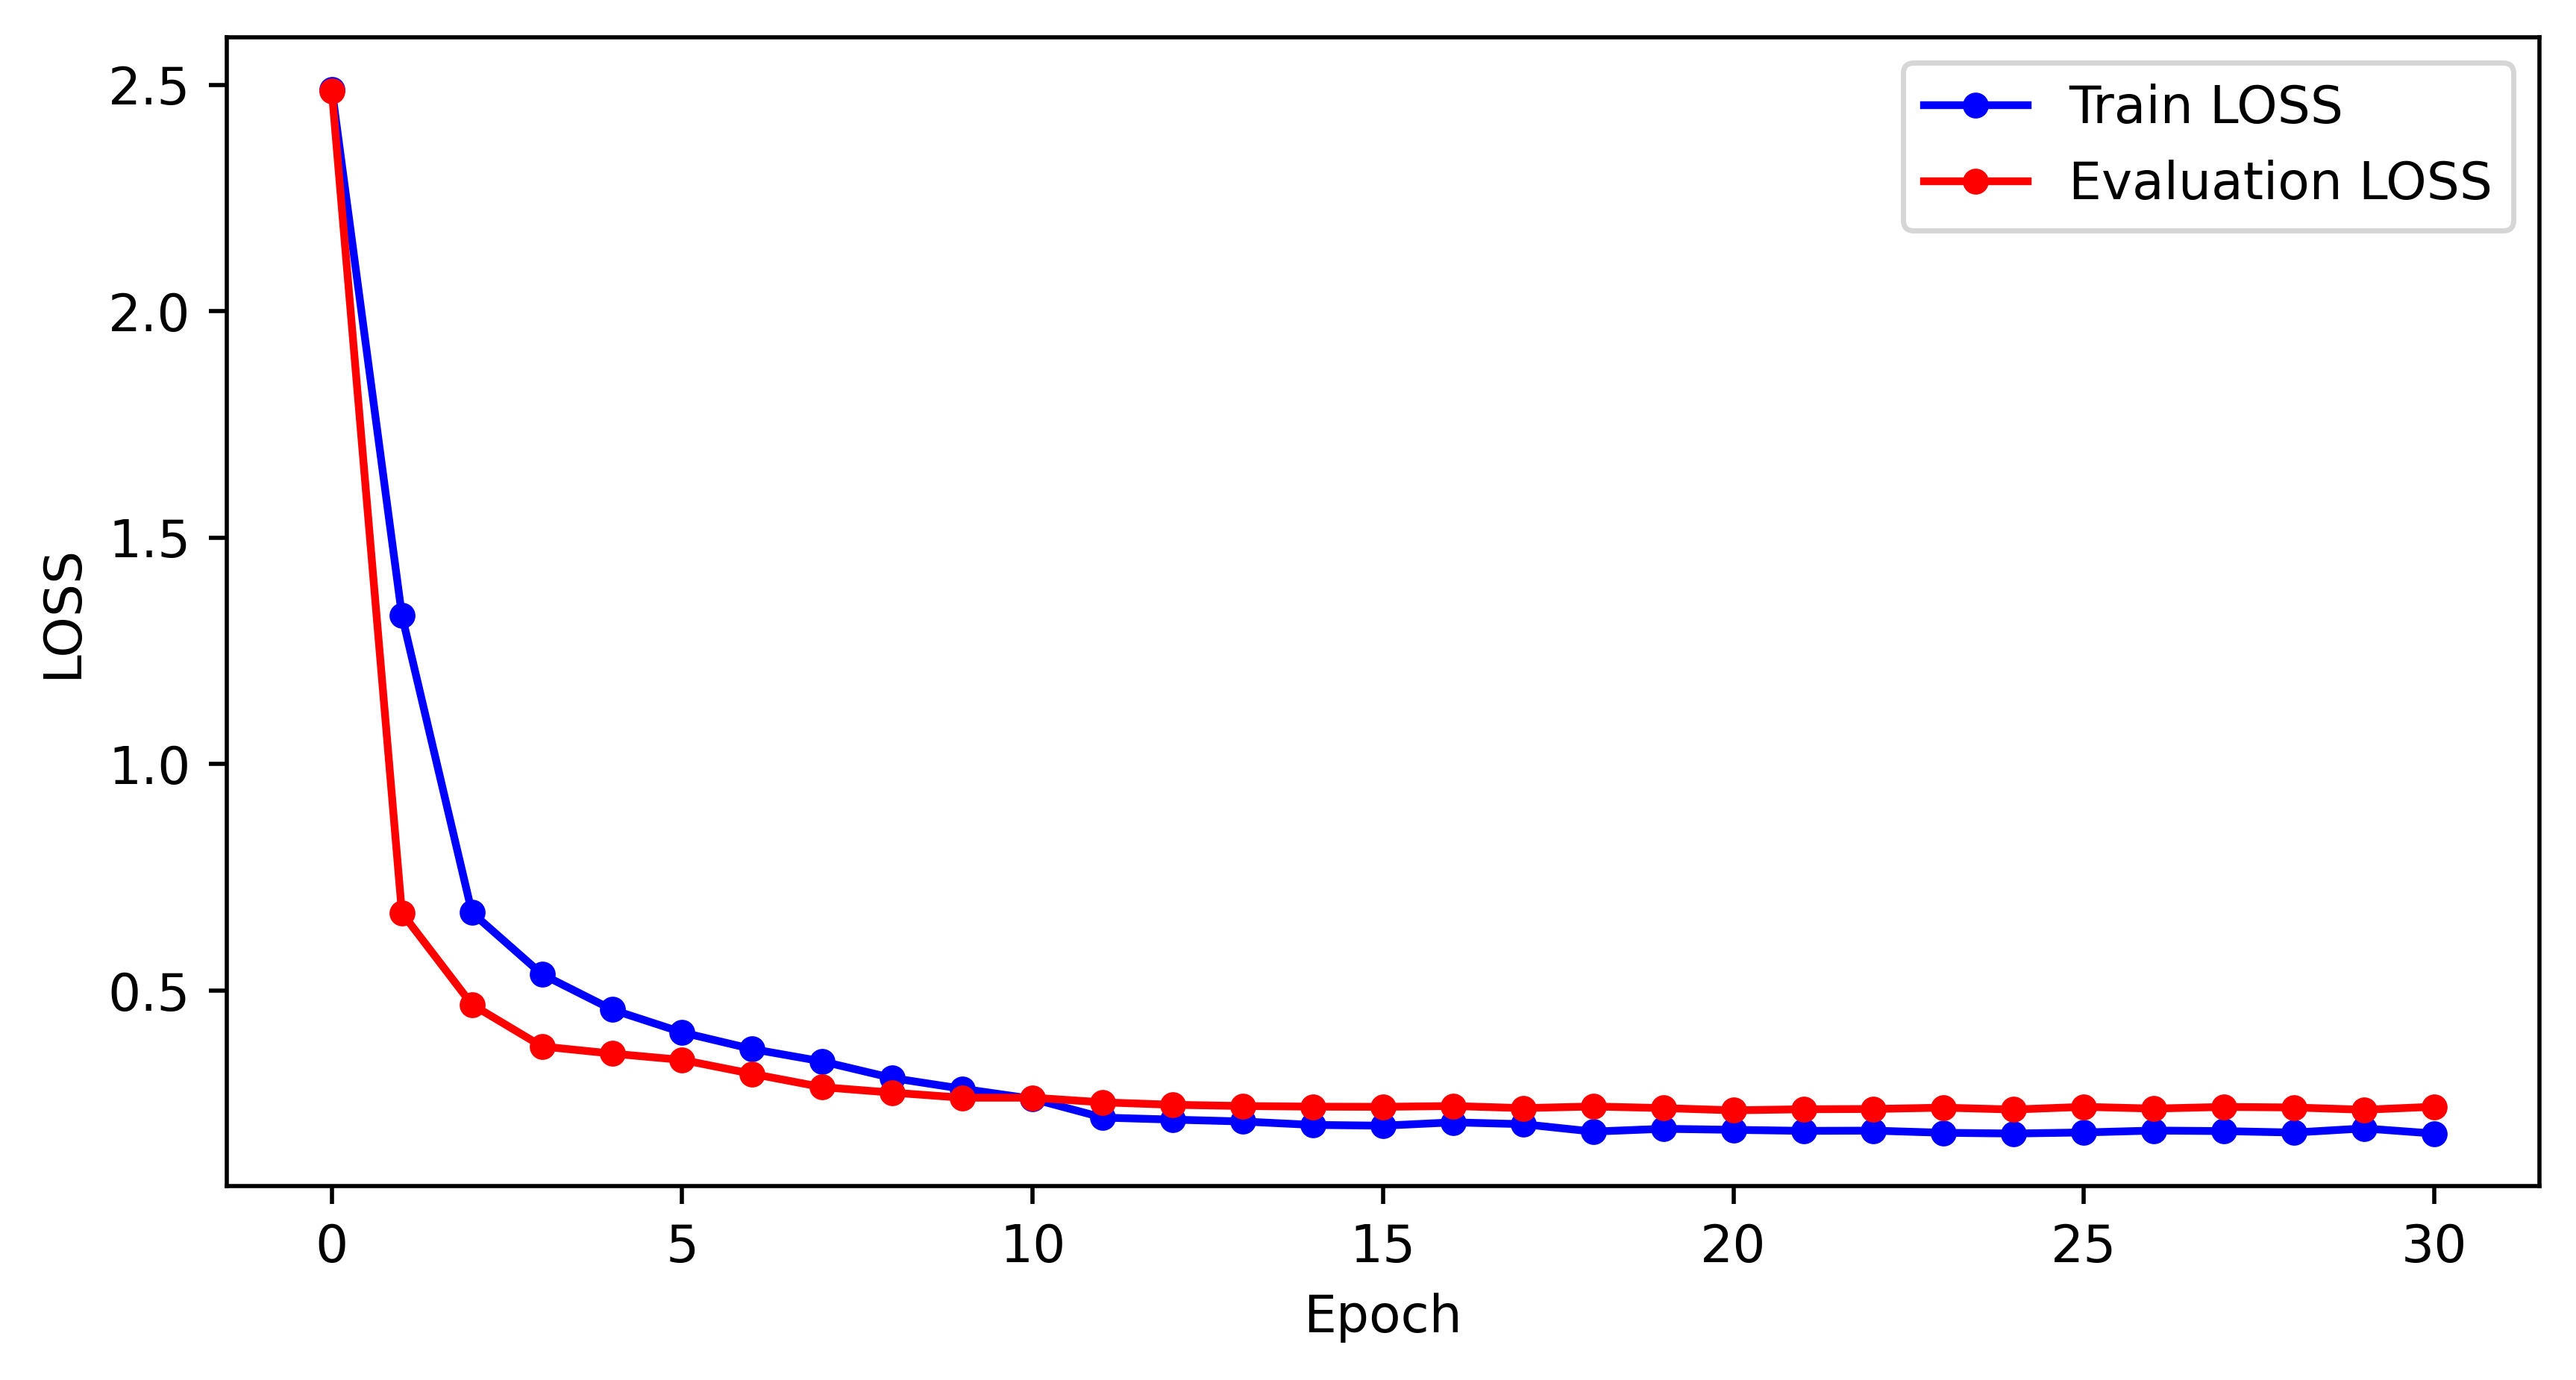

In [ ]:
# Plotting the results (LOSS)
plt.figure(figsize=(8, 4) , dpi=500)
plt.plot(loss_train_history , 'o-', color="blue" , label="Train LOSS"      , markersize=4)
plt.plot(loss_eval_history  , 'o-', color="red"  , label="Evaluation LOSS" , markersize=4)
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend()
plt.show()

# must be saved

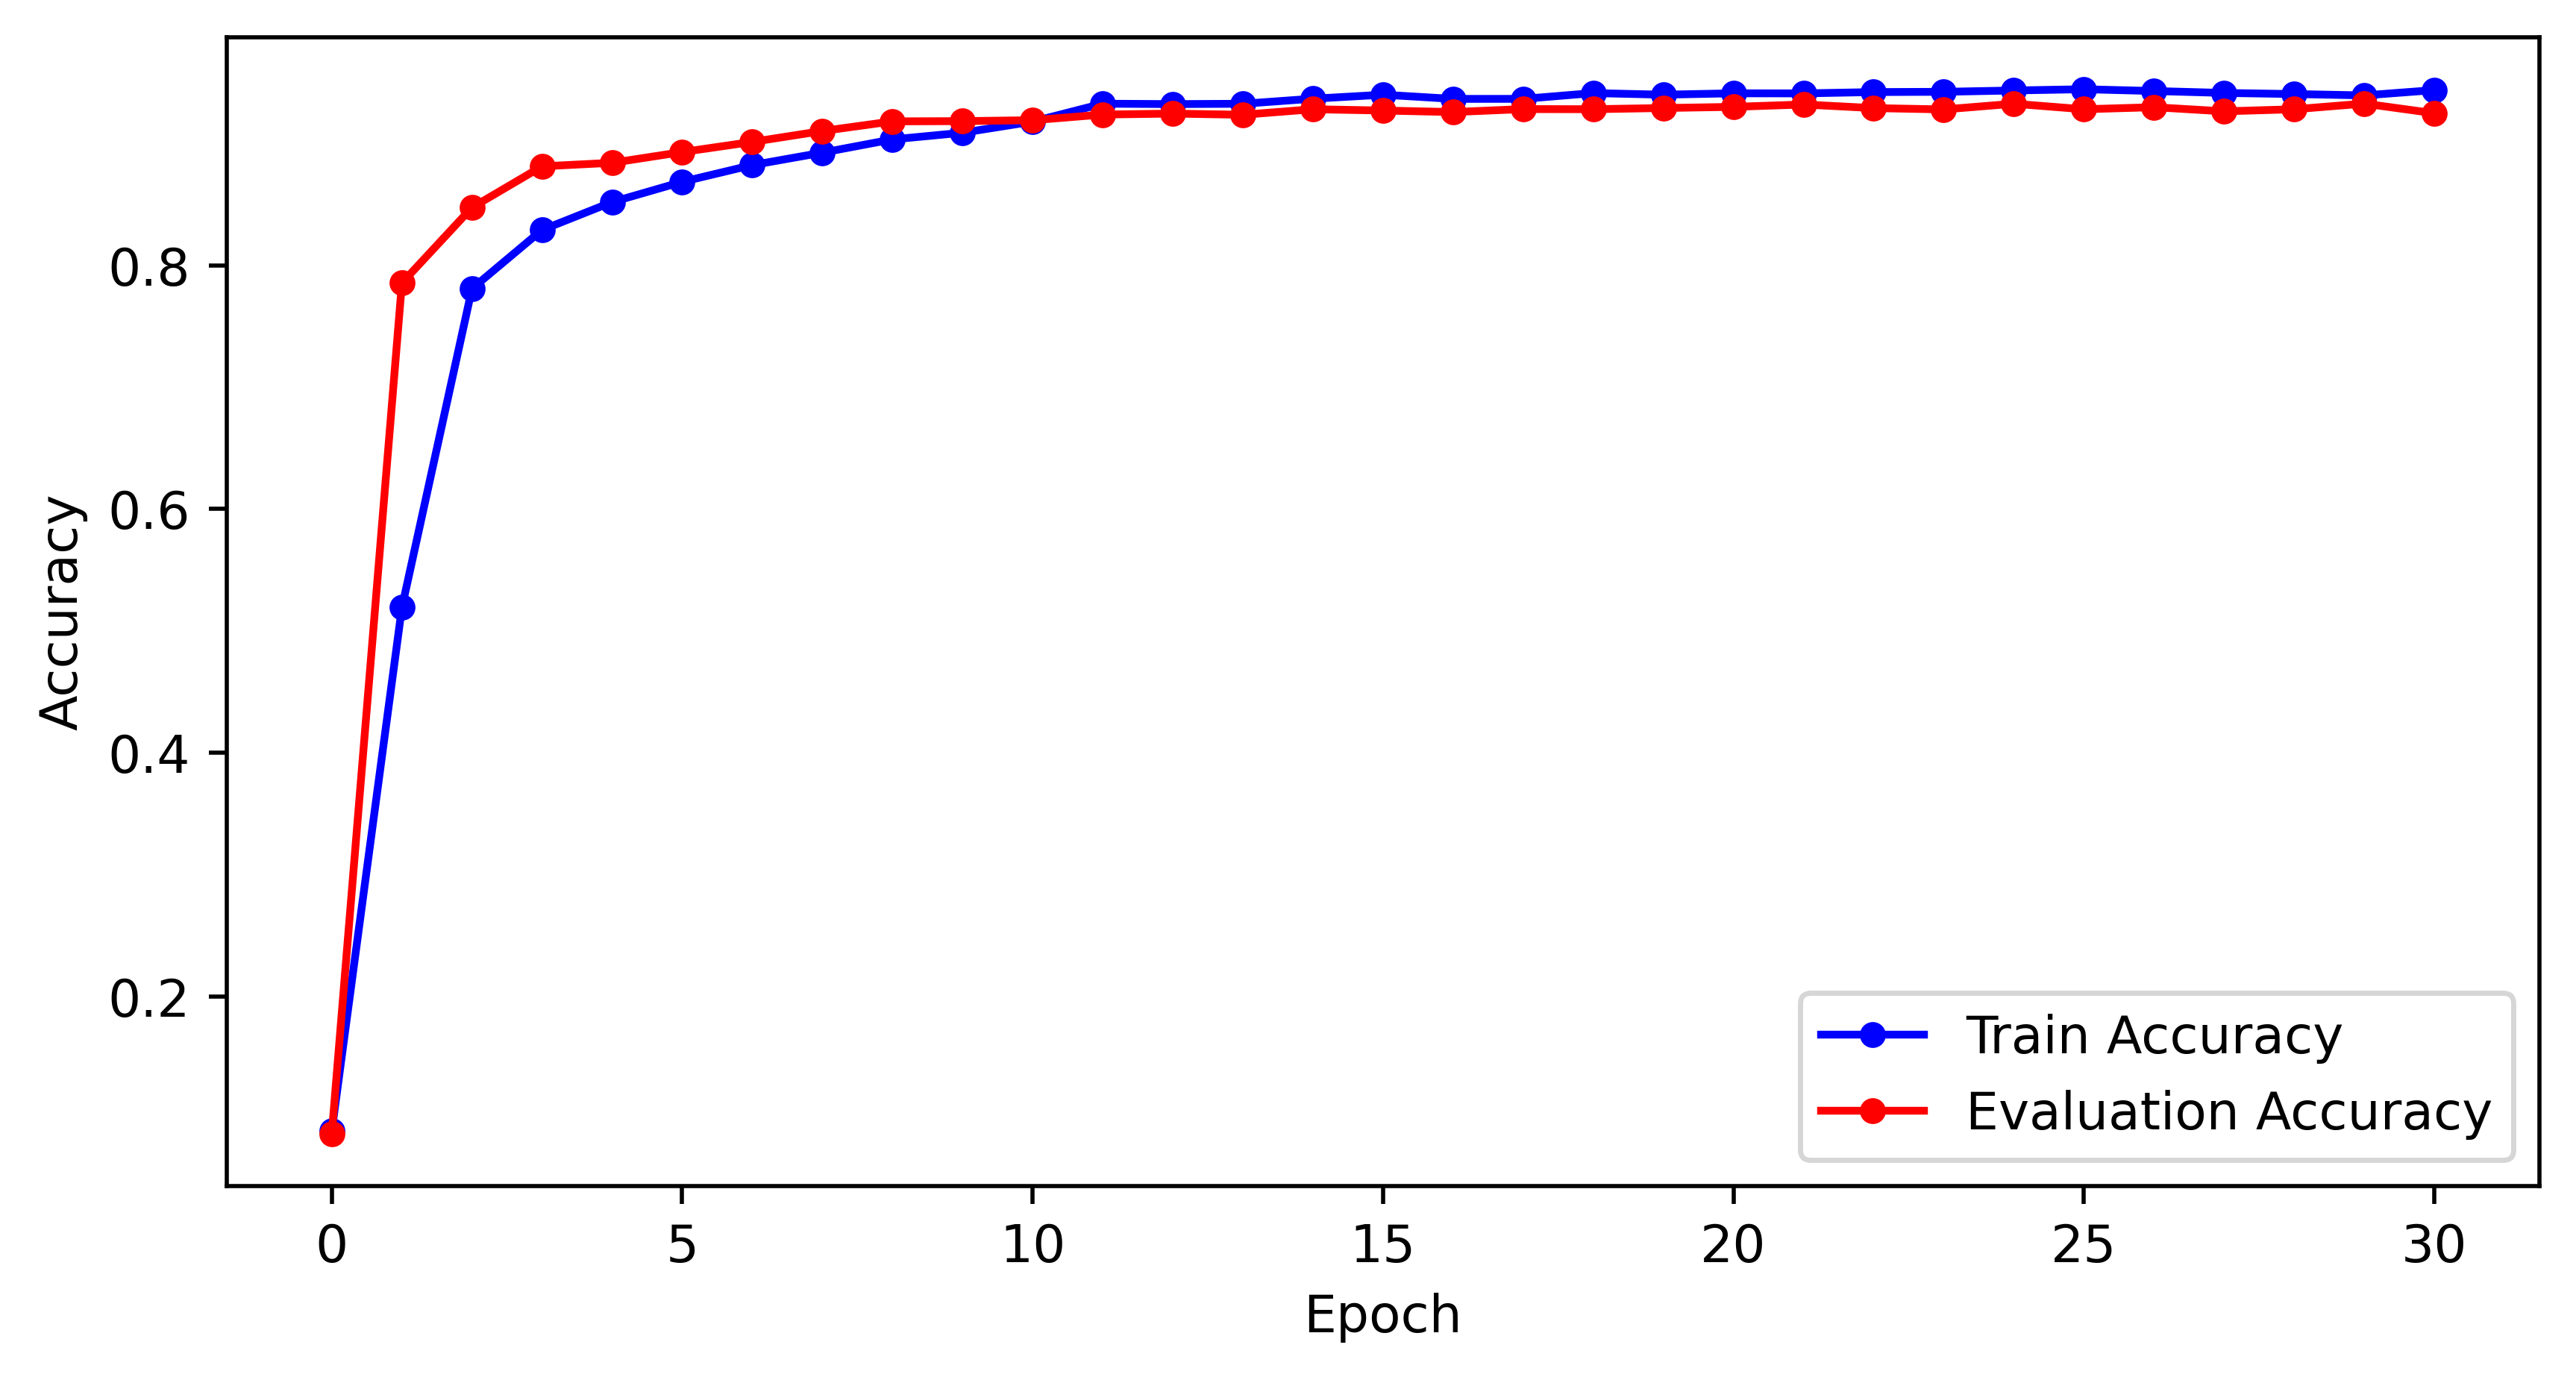

In [ ]:
# Plotting the results (Accuracy)
plt.figure(figsize=(8, 4) , dpi=500)
plt.plot(accuracy_train_history , 'o-' , color="blue" , label="Train Accuracy"      , markersize=4)
plt.plot(accuracy_eval_history  , 'o-' , color="red"  , label="Evaluation Accuracy" , markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# must be saved

## (This is a result - Not a part of code) This section is a hardcode. It includes the average results of different runs (5 runs of code) which shows generalization and robustnes - Due to randomness results may be slightly different. But, the difference in the mean is very very small and almost negligible. This section is obtained by multiple executions, saving the performances in Excel, and plotting the results. Therefore, it must be a hardcode.
We insist once more that the results may slightly be affected by randomness. Nevertheless, if you run the code multiple times (to eliminate the adverse impact of randomness), you will see that our results is quite good and satisfactory.

In [ ]:
import pandas as pd

# Define the data as a list of lists
data = [
    [0, 9.49, 8.43, 9.51, 8.56],
    [1, 33.82, 51.66, 73.51, 80.31],
    [2, 42.49, 60.99, 78.91, 84.76],
    [3, 45.12, 65.58, 81.22, 87.47],
    [4, 48.14, 69.03, 83.34, 88.41],
    [5, 50.58, 71.57, 84.52, 88.58],
    [6, 52.08, 72.45, 84.67, 90.12],
    [7, 52.93, 73.29, 85.62, 90.6],
    [8, 53.66, 74.3, 85.3, 91.2],
    [9, 54.91, 74.98, 86.37, 91.54],
    [10, 54.65, 74.41, 86.21, 91.65],
    [11, 57.77, 75.85, 86.93, 92.38],
    [12, 57.92, 76.07, 87.06, 92.4],
    [13, 58.25, 76.3, 87.21, 92.37],
    [14, 58.29, 76.03, 87.45, 92.51],
    [15, 58.29, 76.56, 87.29, 92.59],
    [16, 58.74, 76.6, 87.65, 92.52],
    [17, 58.65, 76.44, 87.24, 92.69],
    [18, 59.06, 76.74, 87.5, 92.6],
    [19, 58.88, 76.72, 87.5, 92.61],
    [20, 59.25, 76.67, 87.54, 92.69],
    [21, 59.17, 76.99, 87.93, 92.61],
    [22, 59.29, 77.12, 87.87, 92.79],
    [23, 59.34, 76.64, 87.54, 92.74],
    [24, 59.38, 77.01, 87.97, 92.68],
    [25, 59.29, 76.85, 87.75, 92.69],
    [26, 59.02, 76.67, 87.81, 92.59],
    [27, 59.93, 76.96, 87.83, 92.62],
    [28, 59.09, 76.94, 86.66, 92.79],
    [29, 59.33, 76.79, 86.58, 92.55],
    [30, 59.07, 76.97, 87.63, 92.72]
]

# Define the column names
columns = ["Epoch Number", "Eval Acc (image size 32)", "Eval Acc (image size 64)", "Eval Acc (image size 128)", "Eval Acc (image size 256)"]

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Print the DataFrame
# print(df)

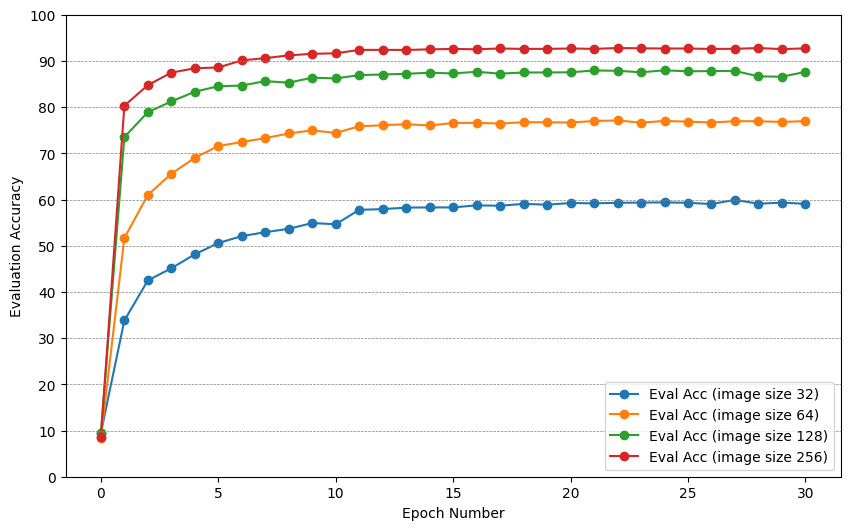

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot a line with marker for each image size
for column in df.columns[1:]:
    plt.plot(df["Epoch Number"], df[column], '-o', label=column)

# Set the y limits
plt.ylim(0, 100)

# Set the x ticks
plt.yticks(range(0, 101, 10))

# Add horizontal lines for y values which are 10,20,30,...,90
for i in range(10, 91, 10):
    plt.axhline(y=i, color='gray', linestyle='--', linewidth=0.5)

# Add labels and title
plt.xlabel("Epoch Number")
plt.ylabel("Evaluation Accuracy")
# plt.title("Evaluation Accuracy for Different Image Sizes Over Epochs")

# Add a legend
plt.legend()

# Save the plot as "Figure 6.jpeg" with dpi=600
plt.savefig("Evaluation accuracy for image sizes.jpeg", dpi=600)

# Show the plot
plt.show()

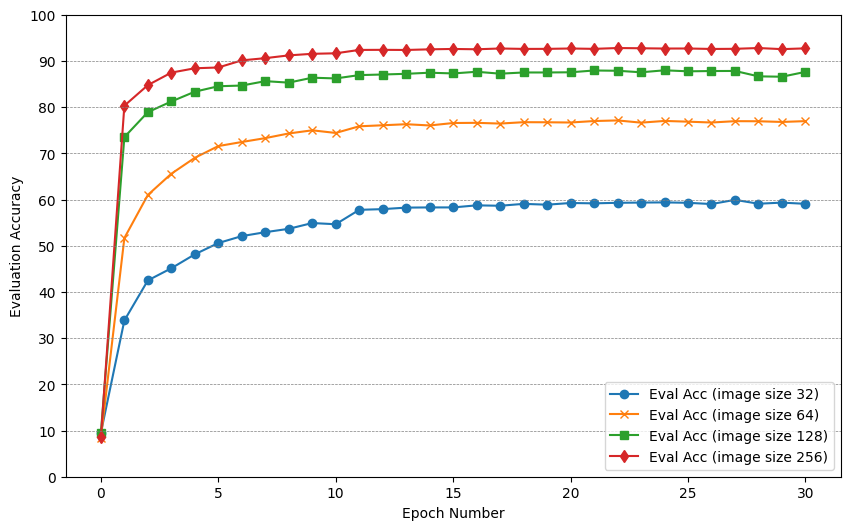

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))

# Define a list of markers
markers = ['o', 'x', 's', 'd']

# Plot a line with different marker for each image size
for i, column in enumerate(df.columns[1:]):
    plt.plot(df["Epoch Number"], df[column], linestyle='-', marker=markers[i], label=column)

# Set the y limits
plt.ylim(0, 100)

# Set the x ticks
plt.yticks(range(0, 101, 10))

# Add horizontal lines for y values which are 10,20,30,...,90
for i in range(10, 91, 10):
    plt.axhline(y=i, color='gray', linestyle='--', linewidth=0.5)

# Add labels and title
plt.xlabel("Epoch Number")
plt.ylabel("Evaluation Accuracy")

# Add a legend
plt.legend()

# Save the plot as "Evaluation accuracy for image sizes.jpeg" with dpi=600
plt.savefig("Evaluation accuracy for image sizes_2.jpeg", dpi=600)

# Show the plot
plt.show()

## <font color="orange">*Beautilful version of Confusion Matrix (using heatmap)*

#### <font color="yellow">*Confusion Matrix using number of data points*

In [ ]:
# Class names
class_names = train_set.classes
print(class_names)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, class_names):
    # Set model to evaluation mode
    model.eval()

    # Initialize lists to store targets and predictions
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move inputs & targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Model => to device
            model = model.to(device)

            # Inputs => model => Outputs
            outputs = model(inputs)

            # Get predictions
            _, predictions = torch.max(outputs, 1)

            # Store targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Compute confusion matrix
    matrix = confusion_matrix(all_targets, all_predictions)

    # Create a heatmap
    plt.figure(figsize=(7,7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print Accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")


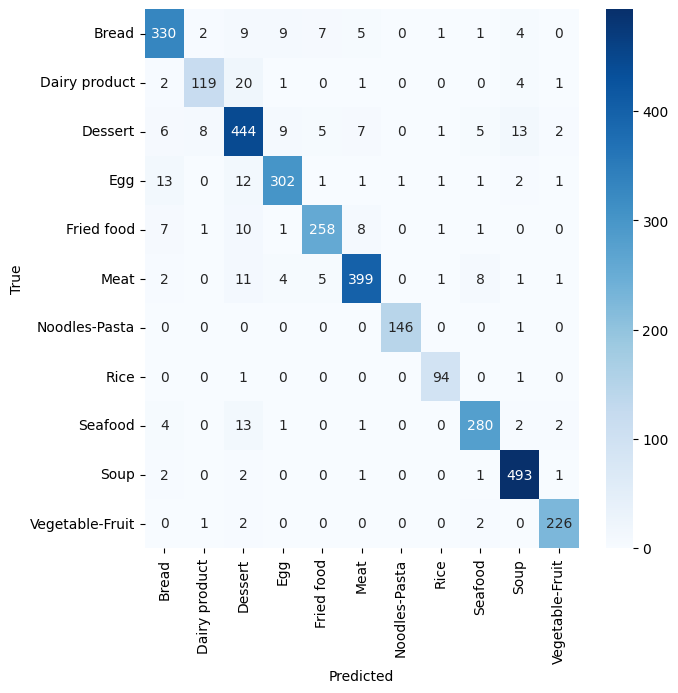


Accuracy: 92.35%


In [ ]:
# Testing the performance
plot_confusion_matrix(model , eval_loader , class_names)

#### <font color="yellow">*Confusion Matrix using percentage of data points (normalized version)*


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, data_loader, class_names):
    # Set model to evaluation mode
    model.eval()

    # Initialize lists to store targets and predictions
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move inputs & targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Model => to device
            model = model.to(device)

            # Inputs => model => Outputs
            outputs = model(inputs)

            # Get predictions
            _, predictions = torch.max(outputs, 1)

            # Store targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Compute confusion matrix
    matrix = confusion_matrix(all_targets, all_predictions)

    # Normalize the confusion matrix (indeed good)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Create a heatmap
    plt.figure(figsize=(9,9))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the figure before showing it
    plt.savefig("Figure 5.jpeg", dpi=600)

    plt.show()

    # Print Accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, data_loader, class_names):
    # Set model to evaluation mode
    model.eval()

    # Initialize lists to store targets and predictions
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move inputs & targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Model => to device
            model = model.to(device)

            # Inputs => model => Outputs
            outputs = model(inputs)

            # Get predictions
            _, predictions = torch.max(outputs, 1)

            # Store targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Compute confusion matrix
    matrix = confusion_matrix(all_targets, all_predictions)

    # Normalize the confusion matrix (indeed good)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Create a heatmap
    plt.figure(figsize=(9,9))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Adjust layout
    plt.tight_layout()

    # Save the figure before showing it
    plt.savefig("Figure 5.jpeg", dpi=600)

    plt.show()

    # Print Accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

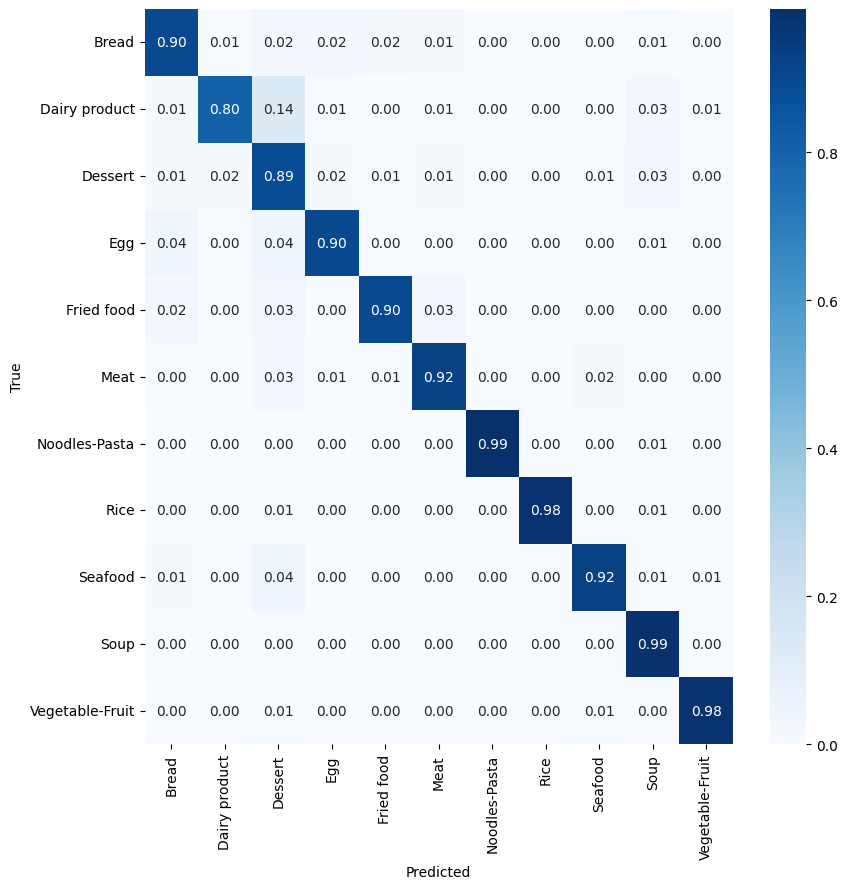


Accuracy: 92.35%


In [ ]:
# Testing the performance
plot_confusion_matrix(model , eval_loader , class_names)

### <font color="orange">*We recommend run the code for different image size (32, 64, 128, 256 are recommended) and evaluate the accuracy while considering time. Yet, if you ensure about 256, the rest are Ok as well. Notably, randomness can have impacts. Thus, averaging is required. We ensured our results*

### <font color="orange">*Do NOT forgert Copyright. It is mine :))*

### Shayan Rokhva - Department of Information Technology Engineering - Faculty of Indutrial and System Engineering - Tarbiat Modares University - Tehran - Iran